In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, f1_score, precision_score, precision_recall_curve, recall_score 
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Features: 

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. fasting blood sugar > 120 mg/dl
6. resting electrocardiographic results (values 0,1,2)
7. maximum heart rate achieved
8. exercise induced angina
9. oldpeak = ST depression induced by exercise relative to rest
10. the slope of the peak exercise ST segment


In [3]:
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


split train and test:

In [5]:
heart = df.copy()

In [6]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
heart.duplicated().sum()

0

In [8]:
x = heart.drop(columns='HeartDisease' , axis=1)
y = heart['HeartDisease']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [10]:
x_train.shape , x_test.shape

((826, 11), (92, 11))

In [11]:
print('Distibution (percent %)')
for col in x_train.select_dtypes(include='object').columns:
    print(f"{col}: {x_train[col].value_counts()/x_train.shape[0]}")
    print('-------------------------------')

Distibution (percent %)
Sex: Sex
M    0.782082
F    0.217918
Name: count, dtype: float64
-------------------------------
ChestPainType: ChestPainType
ASY    0.546005
NAP    0.220339
ATA    0.187651
TA     0.046005
Name: count, dtype: float64
-------------------------------
RestingECG: RestingECG
Normal    0.612591
ST        0.193705
LVH       0.193705
Name: count, dtype: float64
-------------------------------
ExerciseAngina: ExerciseAngina
N    0.590799
Y    0.409201
Name: count, dtype: float64
-------------------------------
ST_Slope: ST_Slope
Flat    0.506053
Up      0.430993
Down    0.062954
Name: count, dtype: float64
-------------------------------


In [12]:
for col in x.select_dtypes(include=['object', 'category']):
    x[col], _ = x[col].factorize()

discrete_features = x.dtypes == int

In [13]:
def make_mi_score(X, y, discrete_features):
    mi_score = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='MI Score', index=X.columns)

    return mi_score.sort_values(ascending=False)

In [14]:
mi_score = make_mi_score(x, y, discrete_features)
mi_score

ST_Slope          0.204171
ExerciseAngina    0.135266
ChestPainType     0.126065
Oldpeak           0.093727
MaxHR             0.074047
Cholesterol       0.071679
Sex               0.055611
Age               0.033702
RestingBP         0.028621
FastingBS         0.026719
RestingECG        0.000000
Name: MI Score, dtype: float64

In [15]:
def plot_mi_score(scores, title: str = None):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(8,4))
    plt.barh(width , scores, color = 'green')
    plt.yticks(width, ticks)
    plt.title(title)

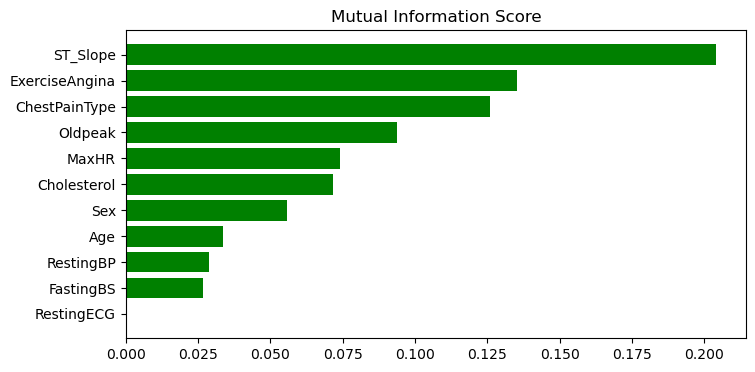

In [16]:
plot_mi_score(mi_score, 'Mutual Information Score')

Heart Disease Percentage:

In [17]:
y_train.value_counts()/y_train.shape[0]

HeartDisease
1    0.549637
0    0.450363
Name: count, dtype: float64

In [18]:
def categorical_plot(data):
    features = data.select_dtypes(include=['category', 'object']).columns
    for _, col in enumerate(features):
        plt.figure(figsize=(5, 4))
        ax = sns.countplot(x = data[col], width=0.5, palette='husl', stat='percent')
        plt.title(f"{col} distribution")
        for bl in ax.containers:
            ax.bar_label(bl, fmt='%.2f', fontsize=12, label_type='center')

    plt.show()

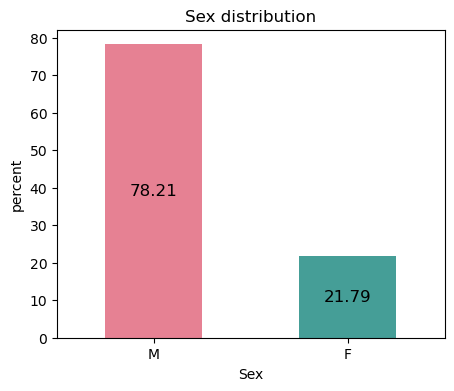

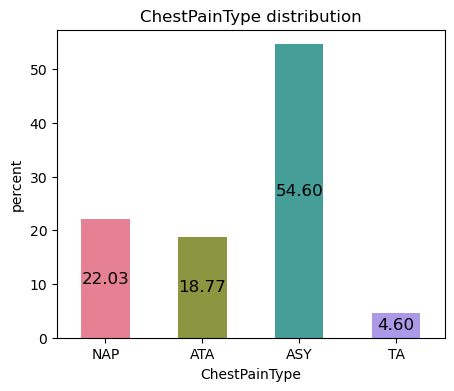

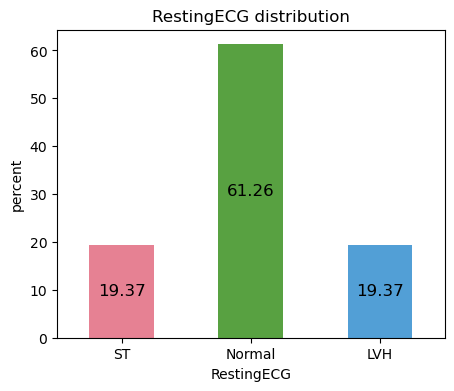

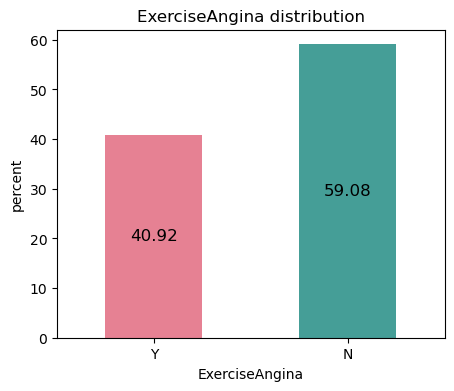

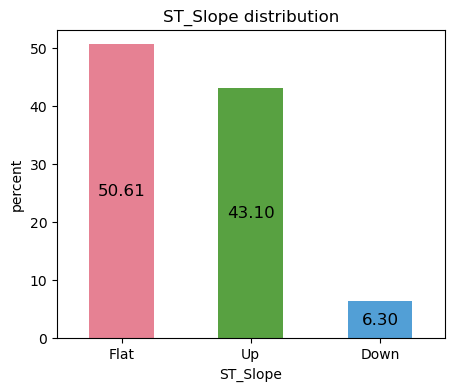

In [19]:
categorical_plot(x_train)

In [20]:
def skewness(data: pd.DataFrame) -> float:
    """return the skewness of numeric data"""
    for col in data.select_dtypes(include=np.number):
        skewness_ = skew(data[col])
        print(f"{col}: \t{skewness_}")

In [21]:
print(skewness(x_train))

Age: 	-0.19214237287962527
RestingBP: 	0.11659128313651707
Cholesterol: 	-0.6740079989067975
FastingBS: 	1.2830084019278327
MaxHR: 	-0.17343451295326176
Oldpeak: 	1.047996373001566
None


In [22]:
x_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,53.478208,132.530266,197.809927,0.230024,136.312349,0.886441
std,9.365708,18.449924,108.421172,0.421103,25.286610,1.070139
min,29.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,118.250000,0.000000
50%,54.000000,130.000000,222.000000,0.000000,138.000000,0.500000
75%,60.000000,140.000000,267.000000,0.000000,155.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [23]:
def kde_plot(data):
    features = data.select_dtypes(include=np.number).columns
    for i, col in enumerate(features):
        plt.figure(figsize=(5, 4))
        ax = sns.kdeplot(x = data[col])
        skewness = skew(data[col])
        plt.title(f"{col} , skewness: {skewness:.4f}")
        

    plt.show()

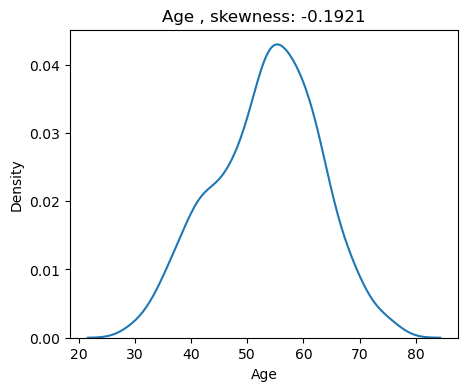

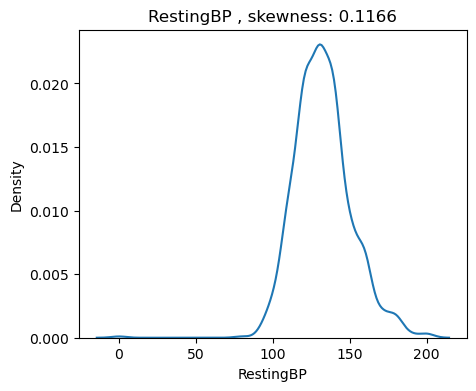

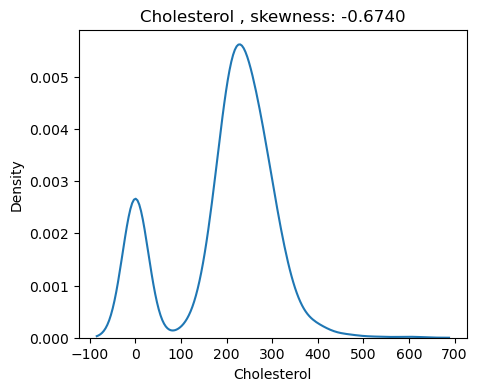

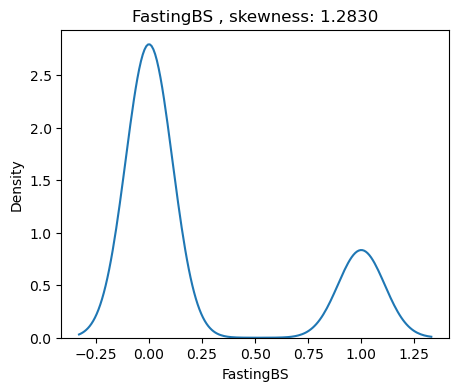

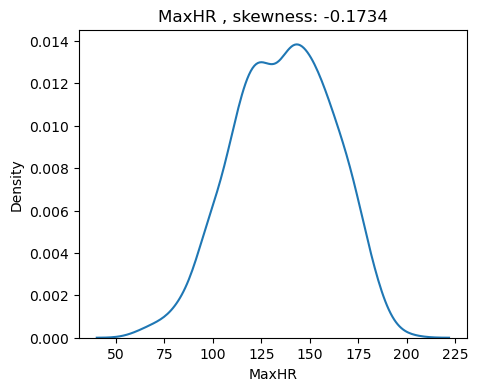

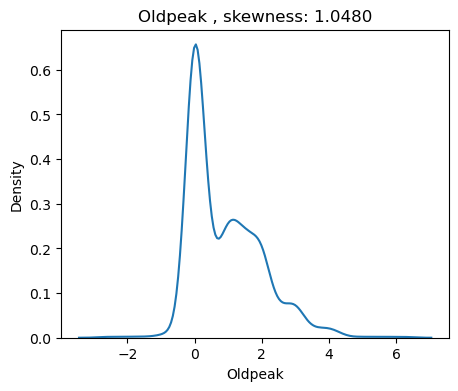

In [24]:
kde_plot(x_train)

In [25]:
def box_plot(data):
    features = data.select_dtypes(include=np.number).columns
    for i, col in enumerate(features):
        plt.figure(figsize=(4, 2))
        sns.boxplot(x = data[col], linecolor='black')
        plt.title(f"{col}")
        

    plt.show()

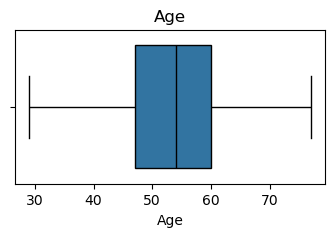

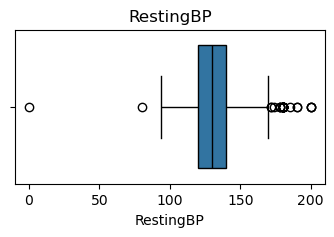

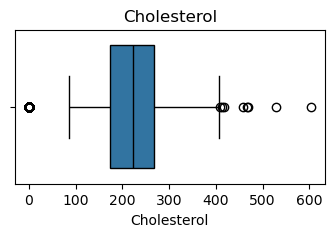

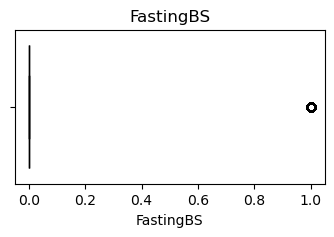

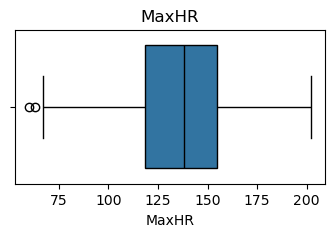

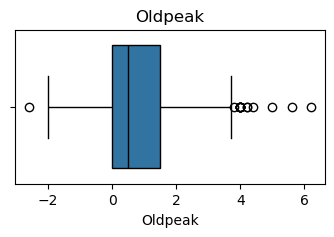

In [26]:
box_plot(x_train)

In [27]:
cat_features = x_train.select_dtypes(include=['object']).columns
num_features = x_train.select_dtypes(include='number').columns

In [28]:
print('Numerical Features: ', num_features)
print('Categorical Features: ', cat_features)

Numerical Features:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')
Categorical Features:  Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [29]:
cat_pipeline = Pipeline([
    ('nulls', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(drop= 'first', handle_unknown='ignore'))
    ])

In [30]:
cat_pipeline.fit_transform([cat_features])

<1x0 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [31]:
num_pipeline = Pipeline([
    ('nulls', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler())
    ])

In [32]:
num_features

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')

In [33]:
x_train['Age'].dtype

dtype('int64')

In [34]:
num_pipeline.fit_transform(x_train[num_features])

array([[ 0.26942112,  0.24240977,  0.09404295,  1.82958149, -0.56634798,
         0.85419999],
       [-0.79895068,  0.40511058,  0.71237784, -0.54657309,  1.13518708,
        -0.8288434 ],
       [-1.54681094, -0.67956151,  0.02021192, -0.54657309,  0.93733417,
         0.1061807 ],
       ...,
       [ 0.69676984, -0.13722546,  0.5093425 , -0.54657309,  0.30420484,
         0.48019035],
       [ 0.69676984,  1.05591384, -1.82556389, -0.54657309, -0.72463031,
        -0.8288434 ],
       [-1.43997376,  0.94744663,  1.79215669, -0.54657309, -0.24978332,
         1.04120481]])

In [35]:
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [36]:
log_reg_clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LogisticRegression(random_state=42))
])

In [37]:
log_reg_clf.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nulls',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('nulls',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=42))])

In [46]:
y_train_predict_log = cross_val_predict(log_reg_clf, x_train, y_train, cv=3) 

In [66]:
conf_matrix_log = confusion_matrix(y_train, y_train_predict_log)
conf_matrix_log

array([[311,  61],
       [ 49, 405]], dtype=int64)

In [48]:
print(classification_report(y_train, y_train_predict_log))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       372
           1       0.87      0.89      0.88       454

    accuracy                           0.87       826
   macro avg       0.87      0.86      0.87       826
weighted avg       0.87      0.87      0.87       826



In [54]:
acc = cross_val_score(log_reg_clf, x_train, y_train, cv=3, scoring='accuracy').mean()
roc_auc = cross_val_score(log_reg_clf, x_train, y_train, cv=3, scoring='roc_auc').mean()
precision = precision_score(y_train, y_train_predict_log)
recall = recall_score(y_train, y_train_predict_log)
f1 = f1_score(y_train, y_train_predict_log)

In [58]:
print(f'accuaracy: {acc:.2f}')
print(f'roc_auc: {roc_auc:.2f}')
print(f'precision: {precision:.2f}')
print(f'recall: {recall:.2f}')
print(f'f1 score: {f1:.2f}')


accuaracy: 0.87
roc_auc: 0.93
precision: 0.87
recall: 0.89
f1 score: 0.88


### SGD Classifier:

In [62]:
sgd_clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', SGDClassifier(random_state=42))
])

In [64]:
sgd_clf.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nulls',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('nulls',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'))])),
                ('classifier', SGDClassifier(random_state=42))])

In [65]:
sgd_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=3)

In [70]:
conf_matrix_sgd = confusion_matrix(y_train, sgd_train_pred)
conf_matrix_sgd

array([[293,  79],
       [ 48, 406]], dtype=int64)

In [71]:
print(classification_report(y_train, sgd_train_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       372
           1       0.84      0.89      0.86       454

    accuracy                           0.85       826
   macro avg       0.85      0.84      0.84       826
weighted avg       0.85      0.85      0.85       826



In [74]:
sgd_acc = cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy').mean()
sgd_roc_auc = cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='roc_auc').mean()
sgd_precision = precision_score(y_train, sgd_train_pred)
sgd_recall = recall_score(y_train, sgd_train_pred)
sgd_f1 = f1_score(y_train, sgd_train_pred)

In [75]:
print(f'accuaracy: {sgd_acc:.2f}')
print(f'roc_auc: {sgd_roc_auc:.2f}')
print(f'precision: {sgd_precision:.2f}')
print(f'recall: {sgd_recall:.2f}')
print(f'f1 score: {sgd_f1:.2f}')

accuaracy: 0.85
roc_auc: 0.92
precision: 0.84
recall: 0.89
f1 score: 0.86


### SVC:

In [77]:
svc_clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', SVC(random_state=42))
])

In [104]:
param_grid_svc = [
    {'classifier__kernel':['rbf'],
     'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #  'classifier__loss': ['hinge', 'squared_hinge'],
    #  'classifier__penalty': ['l1', 'l2']
    },
    {'classifier__kernel':['linear'],
     'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #  'classifier__loss': ['hinge', 'squared_hinge'],
    #  'classifier__penalty': ['l1', 'l2']
    },
    {'classifier__kernel':['poly'],
     'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #  'classifier__loss': ['hinge', 'squared_hinge'],
    #  'classifier__penalty': ['l1', 'l2']
    }
]

In [105]:
grid_search_svc = GridSearchCV(svc_clf, param_grid_svc, verbose=3)

In [106]:
grid_search_svc.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=0.566 total time=   0.0s
[CV 2/5] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=0.570 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=0.564 total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=0.564 total time=   0.0s
[CV 5/5] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=rbf;, score=0.564 total time=   0.0s
[CV 1/5] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.855 total time=   0.0s
[CV 2/5] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.897 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.836 total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__gamma=0.1, class

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('nulls',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('nulls',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_ho...
             param_grid=[{'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'classifier__kernel': ['rbf']},
                         {'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'classifier__kernel': ['linear']},
                         {'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'classifier__kernel': ['poly']}],
             verbose=3)

In [108]:
svc = grid_search_svc.best_params_
svc

{'classifier__C': 30.0, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}

In [111]:
grid_search_svc.best_score_

0.8776925885359621

In [112]:
svc_predict = grid_search_svc.predict(x_test)


In [113]:
mean_squared_error(y_test, svc_predict)

0.15217391304347827

### LinearSVC:

In [125]:
lin_svc_clf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LinearSVC(dual='auto', random_state=42))
])

In [126]:
param_grid_linsvc = [
    {'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__loss': ['hinge', 'squared_hinge'],
     'classifier__penalty': ['l1', 'l2']
    },
    {'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__loss': ['hinge', 'squared_hinge'],
     'classifier__penalty': ['l1', 'l2']
    },
    {'classifier__C': [0.1, 1., 10., 30., 50., 100.],
     'classifier__loss': ['hinge', 'squared_hinge'],
     'classifier__penalty': ['l1', 'l2']
    }
]

In [127]:
grid_search_linsvc = GridSearchCV(lin_svc_clf, param_grid_linsvc, verbose=3)

In [128]:
grid_search_linsvc.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l2;, score=0.861 total time=   0.0s
[CV 2/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l2;, score=0.897 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__loss=hinge, classifier__penalty=l2;, score=0.842 total time=   0.0s
[CV 4/5] END classifier__C=0.1, classifier__loss=hin

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('nulls',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('nulls',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one_ho...
             param_grid=[{'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__loss': ['hinge', 'squared_hinge'],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__loss': ['hinge', 'squared_hinge'],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier__C': [0.1, 1.0, 10.0, 30.0, 50.0, 100.0],
                          'classifier__loss': ['hinge', 'squared_hinge'],
                          'classifier__penalty': ['l1', 'l2']}],
             verbose=3)

In [129]:
grid_search_linsvc.best_params_

{'classifier__C': 1.0,
 'classifier__loss': 'squared_hinge',
 'classifier__penalty': 'l2'}

In [130]:
grid_search_linsvc.best_score_

0.8692369477911648

In [131]:
linsvc_pred = grid_search_linsvc.predict(x_test)

In [132]:
mean_squared_error(y_test, linsvc_pred)

0.14130434782608695